In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
samira1992_promoter_or_not_bioinformatics_dataset_path = kagglehub.dataset_download('samira1992/promoter-or-not-bioinformatics-dataset')

print('Data source import complete.')


Data source import complete.


In [10]:
# Imports
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
import timeit
import io
import IPython.display as display
from PIL import Image
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [249]:
def load_data_kaggle():
	promoter_ = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/promoter.csv')
	non_promoter_ = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/non_promoter.csv')
	patterns_table_ = pd.read_csv('/kaggle/input/promoter-or-not-bioinformatics-dataset/bendability.tsv', header=None, names=['codon','score'], sep='\t')
	promoter_ = promoter_.to_numpy()
	non_promoter_ = non_promoter_.to_numpy()

	return promoter_, non_promoter_, patterns_table_

def load_data_local():
	promoter_ = pd.read_csv(os.path.join(samira1992_promoter_or_not_bioinformatics_dataset_path, 'promoter.csv'))
	non_promoter_ = pd.read_csv(os.path.join(samira1992_promoter_or_not_bioinformatics_dataset_path, 'non_promoter.csv'))
	patterns_table_ = pd.read_csv(os.path.join(samira1992_promoter_or_not_bioinformatics_dataset_path, 'bendability.tsv'), header=None, names=['codon','score'], sep='\t')
	promoter_ = promoter_.to_numpy()
	non_promoter_ = non_promoter_.to_numpy()

	return promoter_, non_promoter_, patterns_table_

def tokenize_stride1(sequences, max_length = 250, k=3):
    adjusted_seqs = [seq[:max_length].ljust(max_length, "N").lower() for seq in sequences.flatten()]
    return np.array([[seq[i:i+k] for i in range(len(seq) - k + 1)] for seq in adjusted_seqs])

def seq_encoding(sequences_kmerized, codons):

    encoded_codons=[]
    for codon in sequences_kmerized:
        if codon not in codons.keys():
          if isinstance(codons['atg'], np.ndarray):
            encoded_codons.append(np.zeros(64))
          else:
            encoded_codons.append(0)

        else:
            encoded_codons.append(codons[codon])

    if isinstance(encoded_codons[0], np.ndarray):
      return np.array(encoded_codons).T.astype(np.float32)
    else:
      return np.array(encoded_codons).astype(np.int32)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=10):
    """
    Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

class Net(nn.Module):
    def __init__(self, embedding_dim=16, num_codons=65, params = [248,128,6,3,1,(3, 2, 1),128,10,6,3,1,(3,2,1),70]):  #num of codons + unknown
        super().__init__()

        self.embedding = nn.Embedding(num_codons, embedding_dim)

        self.linear_relu_stack = nn.Sequential(
        nn.Conv1d(in_channels=params[0],
                out_channels=params[1],
                kernel_size=params[2],
                stride=params[3],
                padding=params[4]),
        nn.BatchNorm1d(params[5]),
        nn.ReLU(),
        nn.MaxPool1d(*params[6]),
        nn.Dropout(p=0.5),

        #nn.Conv1d(in_channels=params[6],
        #          out_channels=params[7],
        #          kernel_size=params[8],
        #          stride=params[9],
        #          padding=params[10]),
        #nn.ReLU(),
        #nn.BatchNorm1d(params[7]),
        #nn.MaxPool1d(*params[6]),
        nn.Flatten(),
        nn.Linear(params[7], round(params[7]/4)),
        nn.ReLU(),
        nn.Linear(round(params[7]/4), round(params[7]/16)),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(round(params[7]/16), round(params[7]/64) ),
        nn.ReLU(),
        #nn.Dropout(p=0.5),
        nn.Linear(round(params[7]/64), 1),
        #nn.ReLU(),
        #nn.Linear(round(params[7]/4), round(params[7]/16)),
        #nn.ReLU(),
        #nn.Linear(round(params[7]/16), 1),
        nn.Sigmoid())


    def forward(self, x, verbose=False):

        if verbose:
            print(f"Input shape: {x.shape}")  # Debugging: Print input shape
            x = self.embedding(x)
            x = torch.transpose(x, 1, 2)
            for layer in self.linear_relu_stack:
              print(f"Before {layer.__class__.__name__}: {x.shape}")
              x = layer(x)
              print(f"After {layer.__class__.__name__}: {x.shape}")
            return x

        else:
          x = self.embedding(x)
          x = torch.transpose(x, 1, 2)
          return self.linear_relu_stack(x)

def plot_metrics(train_loss, test_loss, test_acc, precision, recall, auc):

    epochs = range(1, len(train_loss) + 1)

    plots = []

    # Create a figure
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    # Plot loss curve
    axes[0].plot(epochs, train_loss, label='Train Loss')
    axes[0].plot(epochs, test_loss, label='Test Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curve')
    axes[0].set_ylim(0,1)
    axes[0].legend()

    # Plot accuracy curve
    axes[1].plot(epochs, test_acc, label='Test Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curve')
    axes[1].set_ylim(0, 1)
    axes[1].legend()

    # Plot precision-recall curve
    axes[2].plot(recall, precision, label='Precision-Recall Curve')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].set_ylim(0, 1)
    axes[2].set_xlim(0, 1)
    axes[2].legend()

    auc_roc, (fpr, tpr) = auc
    axes[3].plot(fpr, tpr, label=f"AUC={auc_roc:.4f}")
    axes[3].set_xlabel('FPR')
    axes[3].set_ylabel('TPR')
    axes[3].set_title('AUC-ROC Curve')
    axes[3].set_ylim(0, 1)
    axes[3].set_xlim(0, 1)
    axes[3].legend()

    plt.tight_layout()

    # Save plots to list

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    plt.close(fig)

    return buf


def train_loop(dataloader, model, loss_fn, optimizer, batch_size = 100, verbose=False):

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    losses = []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss_value, correct = 0, 0

    for i, batch in enumerate(dataloader, 0):
        # Compute prediction and loss
        X, y = batch[0].to(device), batch[1].to(device).float()

        #print(f"Inputs dtype: {X.dtype}, Labels dtype: {y.dtype}")
        #print(f"Inputs length: {len(X)}, Labels length: {len(y)}")

        pred = model(X, verbose)
        pred = pred.view(-1)
        train_loss = loss_fn(pred, y)
        train_loss_value += train_loss.item()

        # Backpropagation
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            loss_batch100, current = train_loss.item(), i * batch_size + len(X)
            print(f"Train loss 100th: {loss_batch100:>0.2f}  [{current:>5d}/{size:>5d}]")

    # calculate per epoch
    train_loss_value /= num_batches
    print(f"Avg Train Loss: {train_loss_value:>0.2f}")

    return train_loss_value

def test_loop(dataloader, model, loss_fn, sig_threshold):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):

            # Compute prediction and loss
            X, y = batch[0].to(device), batch[1].to(device).float()
            pred = model(X)
            pred = pred.squeeze()

            test_loss += loss_fn(pred, y).item()

            predicted_labels = (pred >= sig_threshold).float()
            correct += (predicted_labels == y).type(torch.float).sum().item()
            all_probs.extend(pred.cpu().numpy())

            # Store predictions and true labels for metric calculation
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    accuracy = correct / size

    #Precision/Recall and F1-score calculation
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    auc_roc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)

    print(f"Test Metrics: \n Accuracy: {(100 * accuracy):>0.1f}%, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, "
          f"Avg loss: {test_loss:>8f} \n")

    return test_loss, accuracy, precision, recall, auc_roc, (fpr, tpr)

def epochs_loop(train_dataloader, test_dataloader, model, epochs=1, lr=0.01, momentum=0.9, decay=0.0, sig_threshold=0.5, train_debug=False):

    train_loss_epochs, test_loss_epochs, precision_epochs, recall_epochs, acc_epochs, auc_epochs = [], [], [], [], [], []
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=decay)
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # start timer
    loop_time = timeit.default_timer()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        train_loss = train_loop(dataloader = train_dataloader,
                                model = model,
                                loss_fn = loss_fn,
                                optimizer = optimizer,
                                batch_size = batch_size,
                                verbose=train_debug)

        test_loss, accuracy, precision, recall, auc_roc, roc_curve_data = test_loop(test_dataloader, model, loss_fn, sig_threshold)

        # To plot
        train_loss_epochs.append(train_loss)
        test_loss_epochs.append(test_loss)
        precision_epochs.append(precision)
        recall_epochs.append(recall)
        acc_epochs.append(accuracy)
        # stop timer
        print('Time {}'.format(np.round((timeit.default_timer() - loop_time),2)))

    plot = plot_metrics(train_loss=train_loss_epochs,
                        test_loss=test_loss_epochs,
                        test_acc=acc_epochs,
                        precision=precision_epochs,
                        recall=recall_epochs,
                        auc=(auc_roc, roc_curve_data))

    return train_loss_epochs, test_loss_epochs, plot

In [33]:
#promoter, non_promoter, codon_score = load_data_kaggle()

promoter, non_promoter, codon_score = load_data_local()

codon_score_dict = dict(zip(codon_score['codon'], codon_score['score']))

all_raw_sequences = np.concatenate([promoter, non_promoter])

all_labels = labels = np.concatenate([
    np.ones(len(promoter), dtype=int),      #1 promoter
    np.zeros(len(non_promoter), dtype=int)  #0 non-promoter
])

sequences_kmerized = tokenize_stride1(all_raw_sequences)

#codon_to_one_hot = {codon: np.eye(64)[i] for i, codon in enumerate(codon_score_dict)}
#one_hot_seqs = [seq_encoding(seq, codons=codon_to_one_hot) for seq in sequences_kmerized]

codon_to_num = {codon: i+1 for i, codon in enumerate(codon_score_dict)}
random_token_seqs = [seq_encoding(seq, codons=codon_to_num) for seq in sequences_kmerized]

In [158]:

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    random_token_seqs, all_labels, train_size=0.8, test_size=0.2, random_state=42)

train_dataloader, test_dataloader = data_loader(train_inputs, test_inputs, train_labels, test_labels, batch_size=64)



In [ ]:
# Creating net and training

#Test Decay
#mode1 = [0.01, 0.9, 0.0, 30, 64, 0.5]
#mode2 = [0.01, 0.9, 1e-1, 30, 64, 0.5]
#mode3 = [0.01, 0.9, 1e-2, 30, 64, 0.5]
#mode4 = [0.01, 0.9, 1e-3, 30, 64, 0.5]

# Test LR
#mode5 = [0.03, 0.9, 0.0, 30, 64, 0.5]
#mode6 = [0.005, 0.9, 0.0, 30, 64, 0.5]

# random token seqs
mode7 = [0.01, 0.9, 0, 20, 64, 0.5]


list_plots=[]
for mode in [mode7]:
    lr, momentum, decay, epochs, batch_size, sigthr = mode

    variable_data = {
        'lr': lr,
        'momentum': momentum,
        'decay': decay,
        'epochs': epochs,
        'batch_size': batch_size,
        'sigthr': sigthr,
        'arch_params': [16,128,6,3,1,128,(3, 2, 1),5248]}

    # Model
    model = Net(params=variable_data['arch_params'])
    model.to(device)

    # Training
    train_loss, test_loss, plots = epochs_loop(train_dataloader=train_dataloader,
                                              test_dataloader=test_dataloader,
                                              model=model,
                                              epochs=variable_data['epochs'],
                                              lr=variable_data['lr'],
                                              momentum=variable_data['momentum'],
                                              decay=variable_data['decay'],
                                              sig_threshold= variable_data['sigthr'],
                                              train_debug=False)

    list_plots.append(plots)

Epoch 1
-------------------------------
Train loss 100th: 0.75  [   64/48000]
Train loss 100th: 0.69  [ 6464/48000]
Train loss 100th: 0.69  [12864/48000]
Train loss 100th: 0.69  [19264/48000]
Train loss 100th: 0.69  [25664/48000]
Train loss 100th: 0.69  [32064/48000]
Train loss 100th: 0.69  [38464/48000]


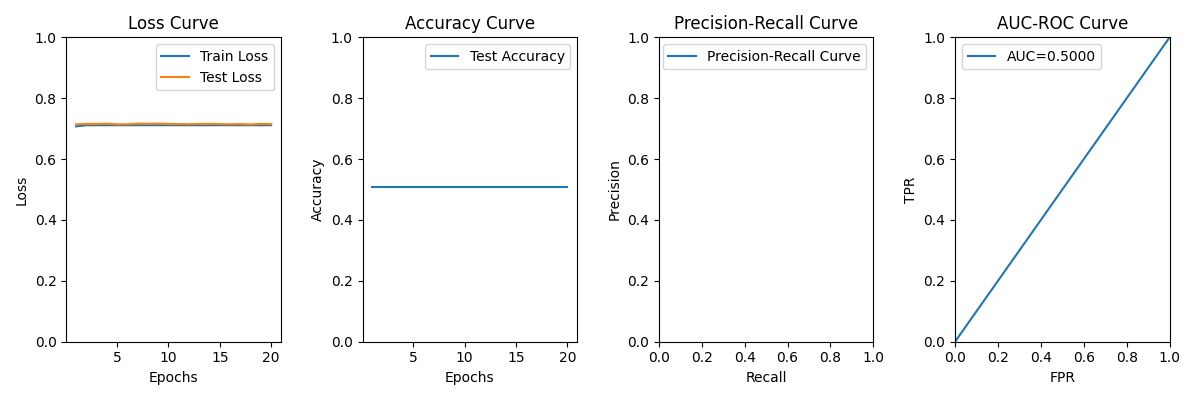

In [234]:
for plot_buf in list_plots:
    img = Image.open(plot_buf)
    display.display(img)